### Imports. Data reading. Defining some functions.

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.scale import FuncScale

In [3]:
import funky as f

In [4]:
heade = ['M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed','kick','Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen']

path_data = './data/'
dyn = '/Dyn/' # Direi che così è facilmente customizzabile per come ogni autistic* si è sistemato i files.
cols = [1,2,3,4,9,13,14,15,16,17,25,27]


In [5]:
def extractor(cluster, path_data=path_data):
    data = pd.DataFrame()
    wichcluster = os.listdir(path_data) #check what your pc does here
    #print(wichcluster)
    if cluster == 'gc':
        cluster = wichcluster[2]
    if cluster == 'nsc':
        cluster = wichcluster[1]
    if cluster == 'ysc':
        cluster = wichcluster[0]
    for i in os.listdir(path_data + cluster + dyn):
        #print(i)
        name = path_data + cluster + dyn + str(i) + '/nth_generation.txt'
        #print(name)
        dataZ=pd.read_csv(name, delimiter=' ', skiprows=1, usecols=cols, names=heade)#, names=heade)
        #dataZ.drop(dataZ.columns[[0, 5, 6, 7, 8, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 24, 26]], axis=1, inplace=True)
        #dataZ.columns = heade
        dataZ['Z'] = float(i)
        data = pd.concat([data, dataZ])
        data = data[data['t_elapsed'] != 136000]
    return data

In [6]:
data_ysc=extractor('ysc')
data_gc=extractor('gc')
data_nsc=extractor('nsc')

In [14]:
data_ysc.head()

,M1,M2,S1,S2,t_pair,t_elapsed,kick,Mrem,Srem,esca_v,Mcluster,gen,Z
0,76.697254,66.639358,0.725403,0.163330,11.967619,34.297146,685.446649,133.884923,0.828087,22.646987,114772.107176,2,0.012
1,69.292415,63.511349,0.711974,0.100949,5.117888,214.598746,301.000496,124.330663,0.813922,15.073360,38737.472733,2,0.012
2,56.687471,54.558071,0.743557,0.239766,21.934368,958.174950,143.781568,103.745950,0.831979,28.420132,187785.696955,2,0.012
3,64.265002,63.641092,0.734500,0.208438,11.856484,291.525094,376.254559,119.458912,0.824124,30.558254,163900.835799,2,0.012
4,80.895422,65.006386,0.747839,0.080874,28.770708,2465.798375,0.000000,136.380622,0.829230,22.090060,176059.087065,2,0.012


In [150]:
def hist2dgraph( x,y, nxbin,nybin, title, axx, axy, vmin, vmax, scale_x='linear', scale_y = 'linear',cmap='Blues'):
    '''
    Analogous od the function in 'funky.py'. 
    Added as input (not necessary) parameter 'cmap' which I need for plotting in the same image different cmaps.
    If changed in funky should give no problems when running different/old code.  
    '''
    if scale_x == 'linear':
        xbin= np.linspace(x.min(),x.max(),nxbin)
        plt.xscale('linear')
    elif scale_x == 'log':
        xbin= np.logspace(np.log10(x.min()),np.log10(x.max()),nxbin)
        plt.xscale('log')
    if scale_y == 'linear':
        ybin= np.linspace(y.min(),y.max(),nybin)
        plt.yscale('linear')
    elif scale_y == 'log':
        ybin= np.logspace(np.log10(y.min()),np.log10(y.max()),nybin)
        plt.yscale('log')
    hist = plt.hist2d(x,y,bins=(xbin,ybin), cmap=cmap, norm=colors.LogNorm( vmin=vmin, vmax=vmax))

    plt.title(title)
    plt.xlabel(axx)
    plt.ylabel(axy)
    return hist

## Understanding the dataset: plots of feature over feature for YSCs, GCs, and NSCs

### Primary Mass vs. Secondary Mass


The first relation we study is the one between the mass of the primary and the mass of the secondary BH. 
We observe that, by construction, the secondary object is always less massive than the first.
We also immediately see that the dataset referring to YSCs has less and less massive objects with respect to the other ones. This is because by definition YSCs are less dense clusters than the others, so they will have less stars and also they will fail to form high-mass, high-generation mergers. 
As we could have expected, we don't observe a correlation between the two features.

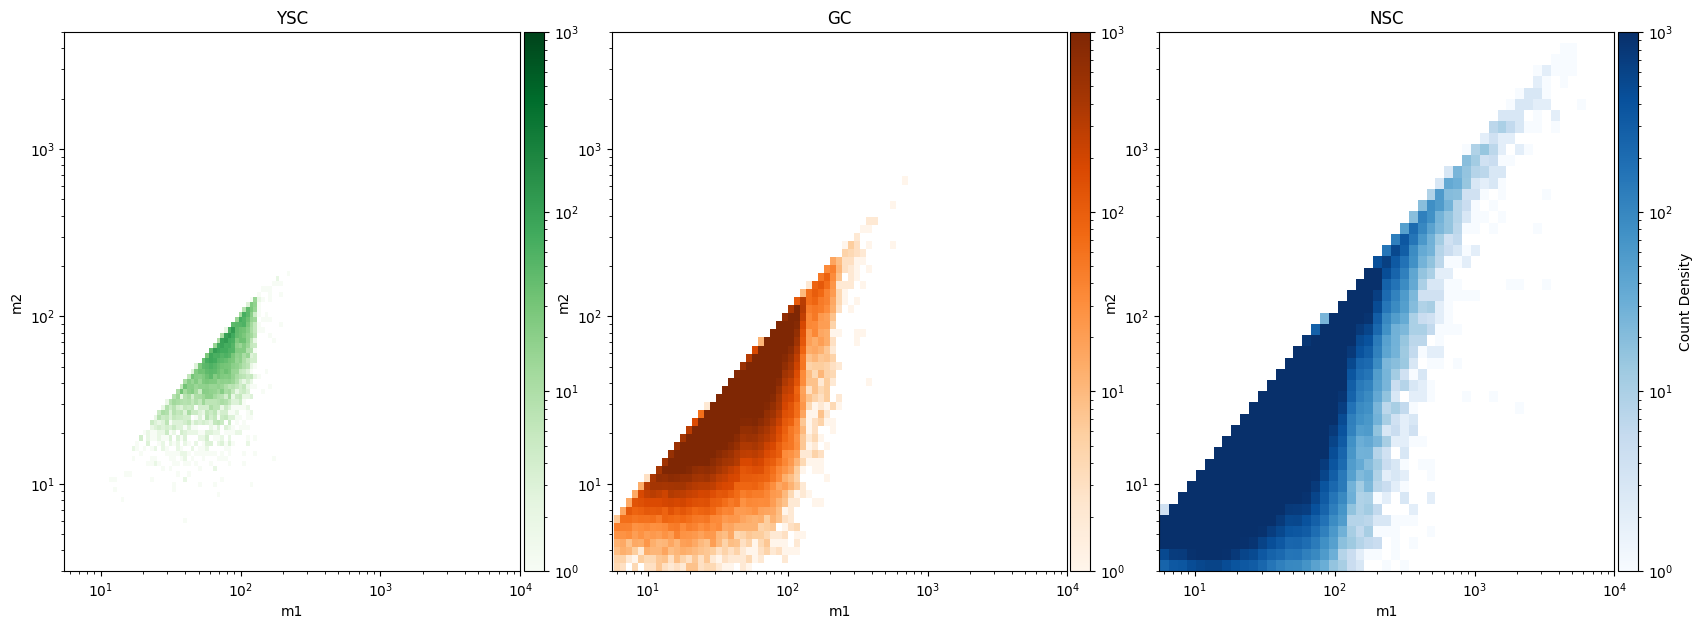

In [167]:
fig,ax=plt.subplots(1,3,figsize=(20,7))
#fig.title("M1 vs. M2", fontsize=16)
plt.sca(ax[0])

hist_ysc=hist2dgraph(data_ysc.M1,data_ysc.M2,50,50,'YSC','m1','m2',1,1e3,scale_x='log',scale_y='log',cmap='Greens')
plt.ylim(3e0,5e3)
plt.xlim(5.5e0,1e4)
cbar_ax = fig.add_axes([0.355, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_ysc[3], cax=cbar_ax, ax=ax[0])

plt.sca(ax[1])
hist_gc=hist2dgraph(data_gc.M1,data_gc.M2,50,50,'GC','m1','m2',1,1e3,scale_x='log',scale_y='log',cmap='Oranges')
plt.ylim(3e0,5e3)
plt.xlim(5.5e0,1e4)
cbar_ax = fig.add_axes([0.628, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_gc[3], cax=cbar_ax, ax=ax[1])

plt.sca(ax[2])
hist_nsc=hist2dgraph(data_nsc.M1,data_nsc.M2,50,50,'NSC','m1','m2',1,1e3,scale_x='log',scale_y='log')
plt.ylim(3e0,5e3)
plt.xlim(5.5e0,1e4)
cbar_ax = fig.add_axes([0.902, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_nsc[3], cax=cbar_ax,ax=ax[2], label="Count Density")

### Remnant Mass vs. Primary Mass

In the following plots we study the correlation between the mass of the remnant and the mass of the primary BH.
We see that the mass of the primary object is, trivially, never higher than the result of the merge.
We observe a strong linear correlation, that indicates that the outcome of the merge is strongly dependent on the primary object when the simulation computes the merge.

Also, we need to take into account the fact that when computing higher generation mergers, the simulation takes as primary object for the new merger the result of a previous merger, i. e. the primary mass for generation >2 is just the remnant mass of a previous merge.

Comparing the three different clusters, we observe (in agreement with the graphs above) that in NSCs there are higher-mass mergers, while in YSCs we are able to create only a limited range in mass of objects.

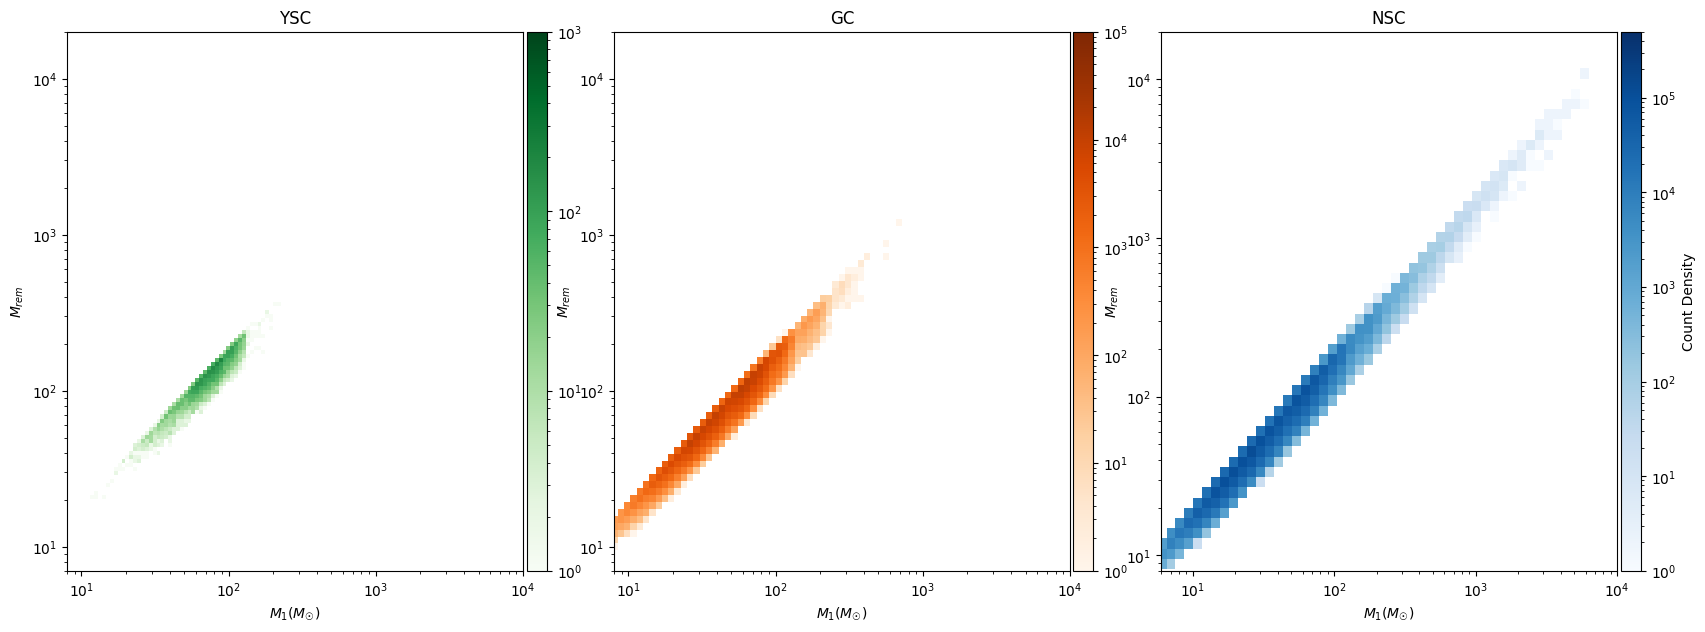

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,7))
#fig.title("M1 vs. M2", fontsize=16)
plt.sca(ax[0])

hist_ysc=hist2dgraph(data_ysc.M1,data_ysc.Mrem,50,50,'YSC',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e3, 'log','log',cmap='Greens')
plt.ylim(7e0,2e4)
plt.xlim(8e0,1e4)
cbar_ax = fig.add_axes([0.355, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_ysc[3], cax=cbar_ax, ax=ax[0])
plt.sca(ax[1])
hist_gc=hist2dgraph(data_gc.M1,data_gc.Mrem,50,50,'GC',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e5, 'log','log',cmap='Oranges')
plt.ylim(7e0,2e4)
plt.xlim(8e0,1e4)
cbar_ax = fig.add_axes([0.628, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_gc[3], cax=cbar_ax, ax=ax[1])
plt.sca(ax[2])
hist_nsc=hist2dgraph(data_nsc.M1,data_nsc.Mrem,50,50,'NSC',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 5e5, 'log','log')
plt.ylim(8e0,2e4)
plt.xlim(6e0,1e4)
cbar_ax = fig.add_axes([0.902, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_nsc[3], cax=cbar_ax,ax=ax[2], label="Count Density")


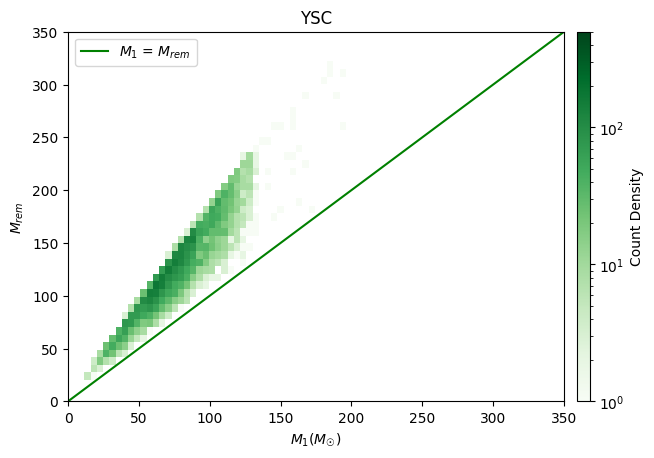

In [ ]:
fig, ax=plt.subplots()
hist_ysc=hist2dgraph(data_ysc.M1,data_ysc.Mrem,50,50,'YSC',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 5e2,cmap='Greens')
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Adjust position [left, bottom, width, height]
plt.colorbar(hist_ysc[3], cax=cbar_ax, label="Count Density")
ax.set_xlim(0,350)
ax.set_ylim(0,350)
x=np.arange(0,350)
y=np.arange(0,350)
y2=2*x
ax.plot(x,y, label=u'$M_1$ = $M_{rem}$',c='green')
#ax.plot(x,y2)
ax.legend()
plt.show()

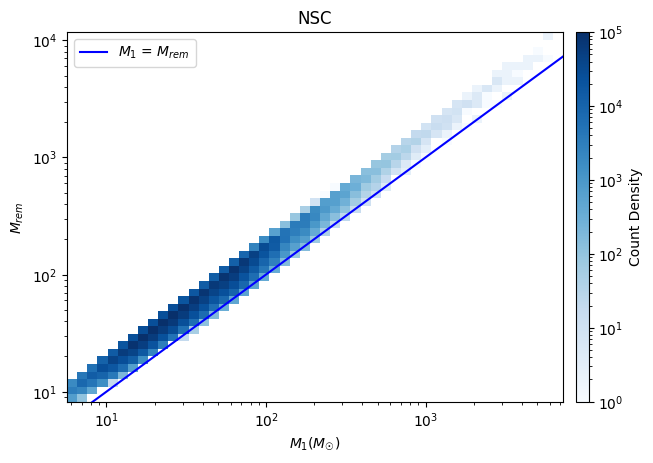

In [118]:
fig,ax=plt.subplots()
x=data_nsc.M1
y=data_nsc.Mrem
vmin=1
vmax=1e5
nybin=50
nxbin=50
ybin= np.logspace(np.log10(y.min()),np.log10(y.max()),nybin)
xbin= np.logspace(np.log10(x.min()),np.log10(x.max()),nxbin)

hist= ax.hist2d(x,y,bins=(xbin,ybin), cmap='Blues', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_title('NSC')
ax.set_xlabel(u'$M_1 (M_\u2609)$')
ax.set_ylabel(u'$M_{rem}$')
ax.set_xscale('log')
ax.set_yscale('log')
x=np.arange(0,int(10e4))
y=x
ax.plot(x,y, label=u'$M_1$ = $M_{rem}$',c='blue')
ax.legend()


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density",)
plt.show()

### Remnant mass vs. Secondary Mass


We quickly show for comparison the distribution of objects using as features the secondary mass and the remnant mass.
We get for all three distributions that the remnant mass is always higher than the secondary mass, in agreement with what we find for the primary mass.
This time we do not observe a strong correlation between the two features.

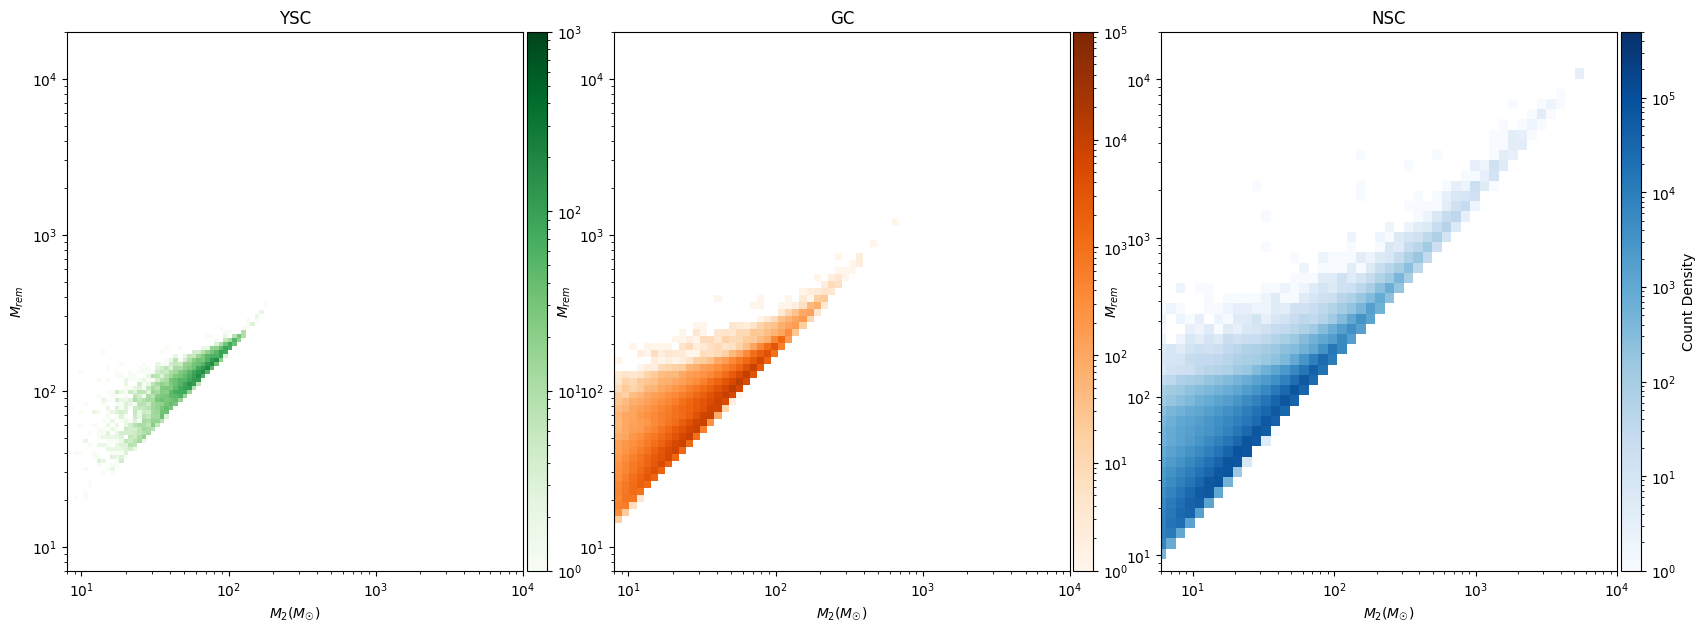

In [77]:
fig,ax=plt.subplots(1,3,figsize=(20,7))
#fig.title("M1 vs. M2", fontsize=16)
plt.sca(ax[0])

hist_ysc=hist2dgraph(data_ysc.M2,data_ysc.Mrem,50,50,'YSC',u'$M_2 (M_\u2609)$', u'$M_{rem}$', 1, 1e3, 'log','log',cmap='Greens')
plt.ylim(7e0,2e4)
plt.xlim(8e0,1e4)
cbar_ax = fig.add_axes([0.355, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_ysc[3], cax=cbar_ax, ax=ax[0])
plt.sca(ax[1])
hist_gc=hist2dgraph(data_gc.M2,data_gc.Mrem,50,50,'GC',u'$M_2 (M_\u2609)$', u'$M_{rem}$', 1, 1e5, 'log','log',cmap='Oranges')
plt.ylim(7e0,2e4)
plt.xlim(8e0,1e4)
cbar_ax = fig.add_axes([0.628, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_gc[3], cax=cbar_ax, ax=ax[1])
plt.sca(ax[2])
hist_nsc=hist2dgraph(data_nsc.M2,data_nsc.Mrem,50,50,'NSC',u'$M_2 (M_\u2609)$', u'$M_{rem}$', 1, 5e5, 'log','log')
plt.ylim(8e0,2e4)
plt.xlim(6e0,1e4)
cbar_ax = fig.add_axes([0.902, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]

fig.colorbar(hist_nsc[3], cax=cbar_ax,ax=ax[2], label="Count Density")


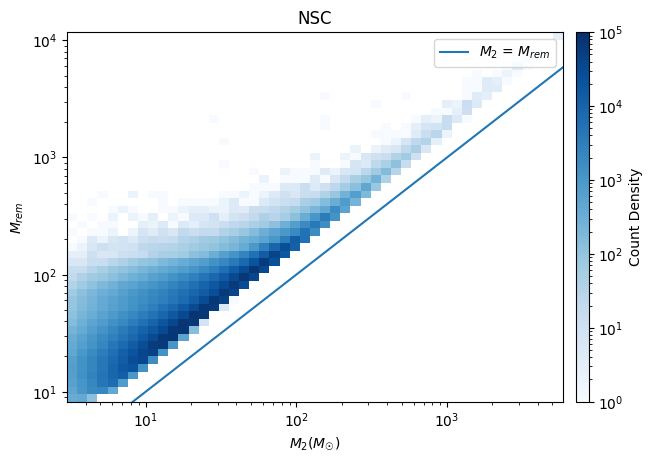

In [88]:
fig,ax=plt.subplots()
x=data_nsc.M2
y=data_nsc.Mrem
vmin=1
vmax=1e5
nybin=50
nxbin=50
ybin= np.logspace(np.log10(y.min()),np.log10(y.max()),nybin)
xbin= np.logspace(np.log10(x.min()),np.log10(x.max()),nxbin)

hist= ax.hist2d(x,y,bins=(xbin,ybin), cmap='Blues', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_title('NSC')
ax.set_xlabel(u'$M_2 (M_\u2609)$')
ax.set_ylabel(u'$M_{rem}$')
ax.set_xscale('log')
ax.set_yscale('log')
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")
x2=range(0,int(1e5))
y2=x2
ax.plot(x2,y2, label=u'$M_2$ = $M_{rem}$')
ax.legend()
plt.show()

### Remnant Mass vs. Total Pre-Merge Mass

We take as new feature the sum of primary and secondary mass and we plot it against the remnant mass. We then compare it with the relation we found between the remnant and the primary mass. 
We observe an even stronger correlation 1:1 than the one we found for the primary mass, indicating that the remnant mass is almost equal to the sum of the masses of the merged BHs. 


In [ ]:
for df in [data_ysc,data_gc,data_nsc]:
    df['Msum']=df.M1 + df.M2
data_nsc.head()

,M1,M2,S1,S2,t_pair,t_elapsed,kick,Mrem,Srem,esca_v,Mcluster,gen,Z,Msum
0,69.094208,57.670705,0.711019,0.128699,21.438521,69.894253,140.429345,118.529632,0.824918,100.738543,1.367033e+06,2,0.012,126.764913
1,38.063741,27.883363,0.734012,0.237416,51.203516,251.268351,297.785549,61.471238,0.847818,115.854632,1.910889e+06,2,0.012,65.947104
2,24.989444,16.916495,0.725597,0.109035,48.154724,1346.827550,139.837902,39.195086,0.839305,75.571979,7.917869e+05,2,0.012,41.905938
3,14.042051,11.606979,0.732162,0.061596,47.724524,568.277129,1251.734444,24.000409,0.822013,89.027333,7.019308e+05,2,0.012,25.649030
4,16.814667,15.241542,0.717129,0.162880,20.372879,195.462327,572.048708,29.959652,0.823334,108.498143,7.039505e+05,2,0.012,32.056208


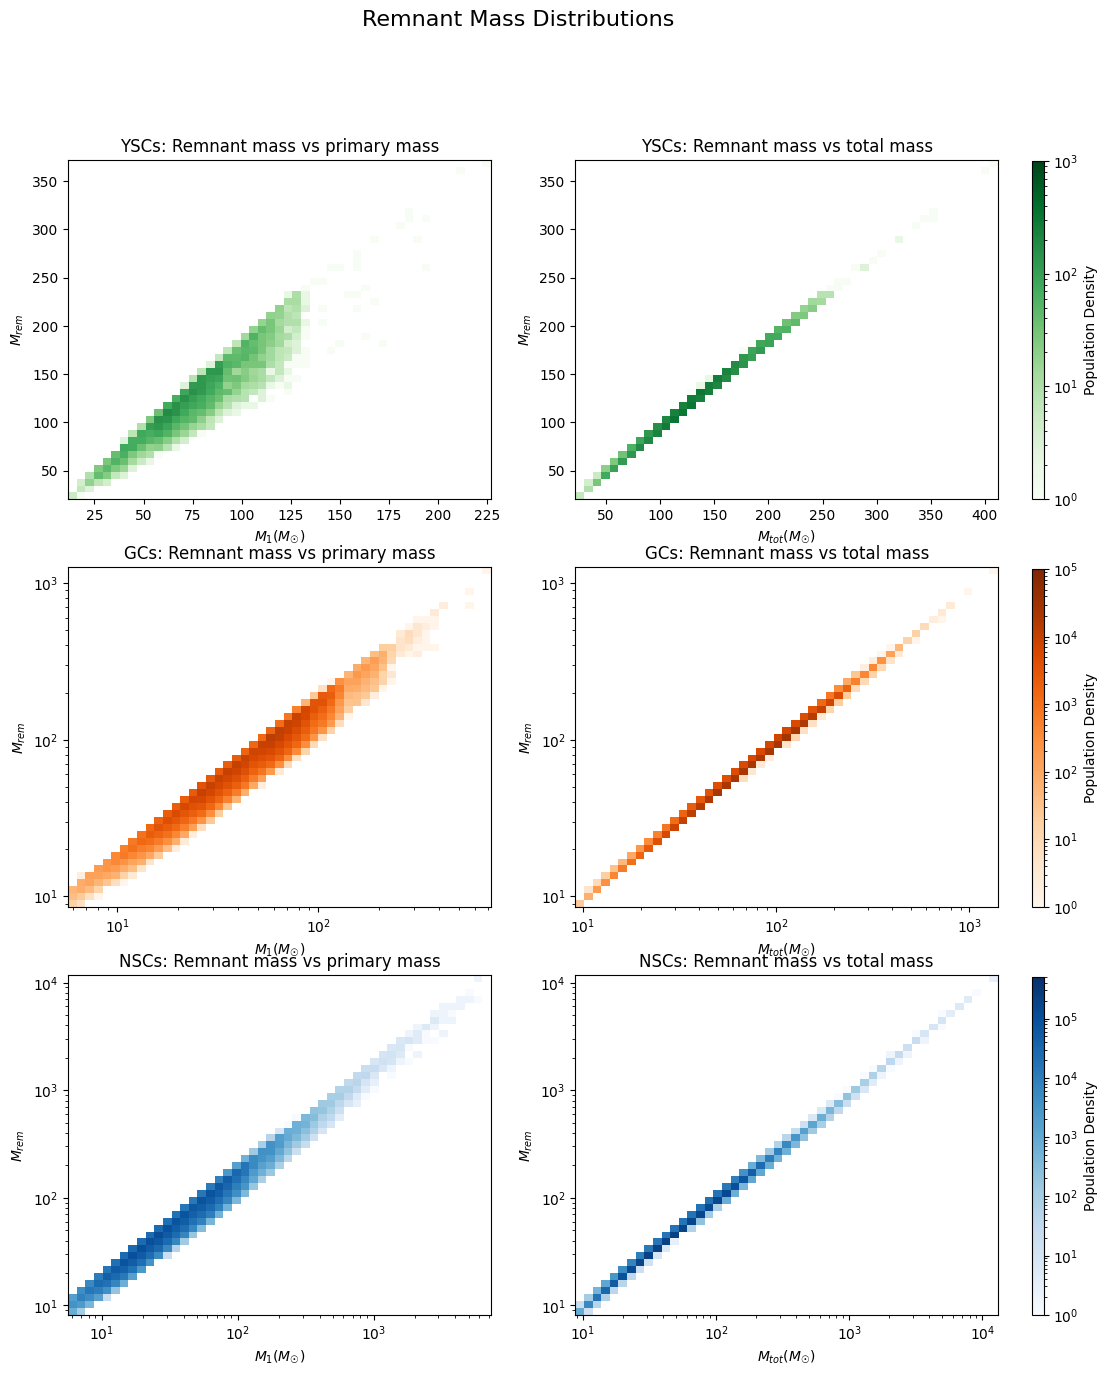

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(12,15))
fig.suptitle("Remnant Mass Distributions", fontsize=16)
plt.sca(ax[0,0])
hist = f.hist2dgraph(data_ysc.M1,data_ysc.Mrem,50,50,'YSCs: Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e3, cmap='Greens')
plt.sca(ax[0,1])
hist2 = f.hist2dgraph(data_ysc.Msum,data_ysc.Mrem,50,50,'YSCs: Remnant mass vs total mass',u'$M_{tot} (M_\u2609)$', u'$M_{rem}$', 1, 1e3,cmap='Greens')
cbar_ax = fig.add_axes([0.928, 0.654, 0.01, 0.225])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist2[3], cax=cbar_ax, ax=ax[0,1],label='Population Density')


plt.sca(ax[1,0])
hist = f.hist2dgraph(data_gc.M1,data_gc.Mrem,50,50,'GCs: Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e5, 'log','log',cmap='Oranges')
plt.sca(ax[1,1])
hist2 = f.hist2dgraph(data_gc.Msum,data_gc.Mrem,50,50,'GCs: Remnant mass vs total mass',u'$M_{tot} (M_\u2609)$', u'$M_{rem}$', 1, 1e5, 'log','log',cmap='Oranges')
cbar_ax = fig.add_axes([0.928, 0.382, 0.01, 0.225])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist2[3], cax=cbar_ax, ax=ax[1,1],label='Population Density')

plt.sca(ax[2,0])
hist = f.hist2dgraph(data_nsc.M1,data_nsc.Mrem,50,50,'NSCs: Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 5e5, 'log','log')
plt.sca(ax[2,1])
hist2 = f.hist2dgraph(data_nsc.Msum,data_nsc.Mrem,50,50,'NSCs: Remnant mass vs total mass',u'$M_{tot} (M_\u2609)$', u'$M_{rem}$', 1, 5e5, 'log','log')
cbar_ax = fig.add_axes([0.928, 0.11, 0.01, 0.225])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist2[3], cax=cbar_ax, ax=ax[2,1],label='Population Density')


### Remnant Mass vs. Primary Spin

remnant vs spin deve tener conto delle generazioni.
si vede che lo spin del remnant parte da una distribuzione : spin ha picco centrale nelle prime generazioni e rimane piccato per ysc, per gli altri si picca ddopo
Spin secondario invece è a due picchi, uno come l'altro e uno più piccolo. Condizioni iniziali, punto. è figo vedere che lo spin del remnant si sposta verso 1 progressivamente perchè lo spin nel remnant diventa spin primario nella gen successiva ed è circa la somma dei due spin. C'è una formula più specifica nel paper. 

In [158]:
data_ysc_a=data_ysc[data_ysc['gen']==2]
data_gc_a=data_gc[data_gc['gen']==2]
data_nsc_a=data_nsc[data_nsc['gen']==2]

data_ysc_b=data_ysc[data_ysc['gen']==3]
data_gc_b=data_gc[data_gc['gen']==3]
data_nsc_b=data_nsc[data_nsc['gen']==3]

data_ysc_c=data_ysc[data_ysc['gen']>3]
data_gc_c=data_gc[data_gc['gen']>3]
data_nsc_c=data_nsc[data_nsc['gen']>3]

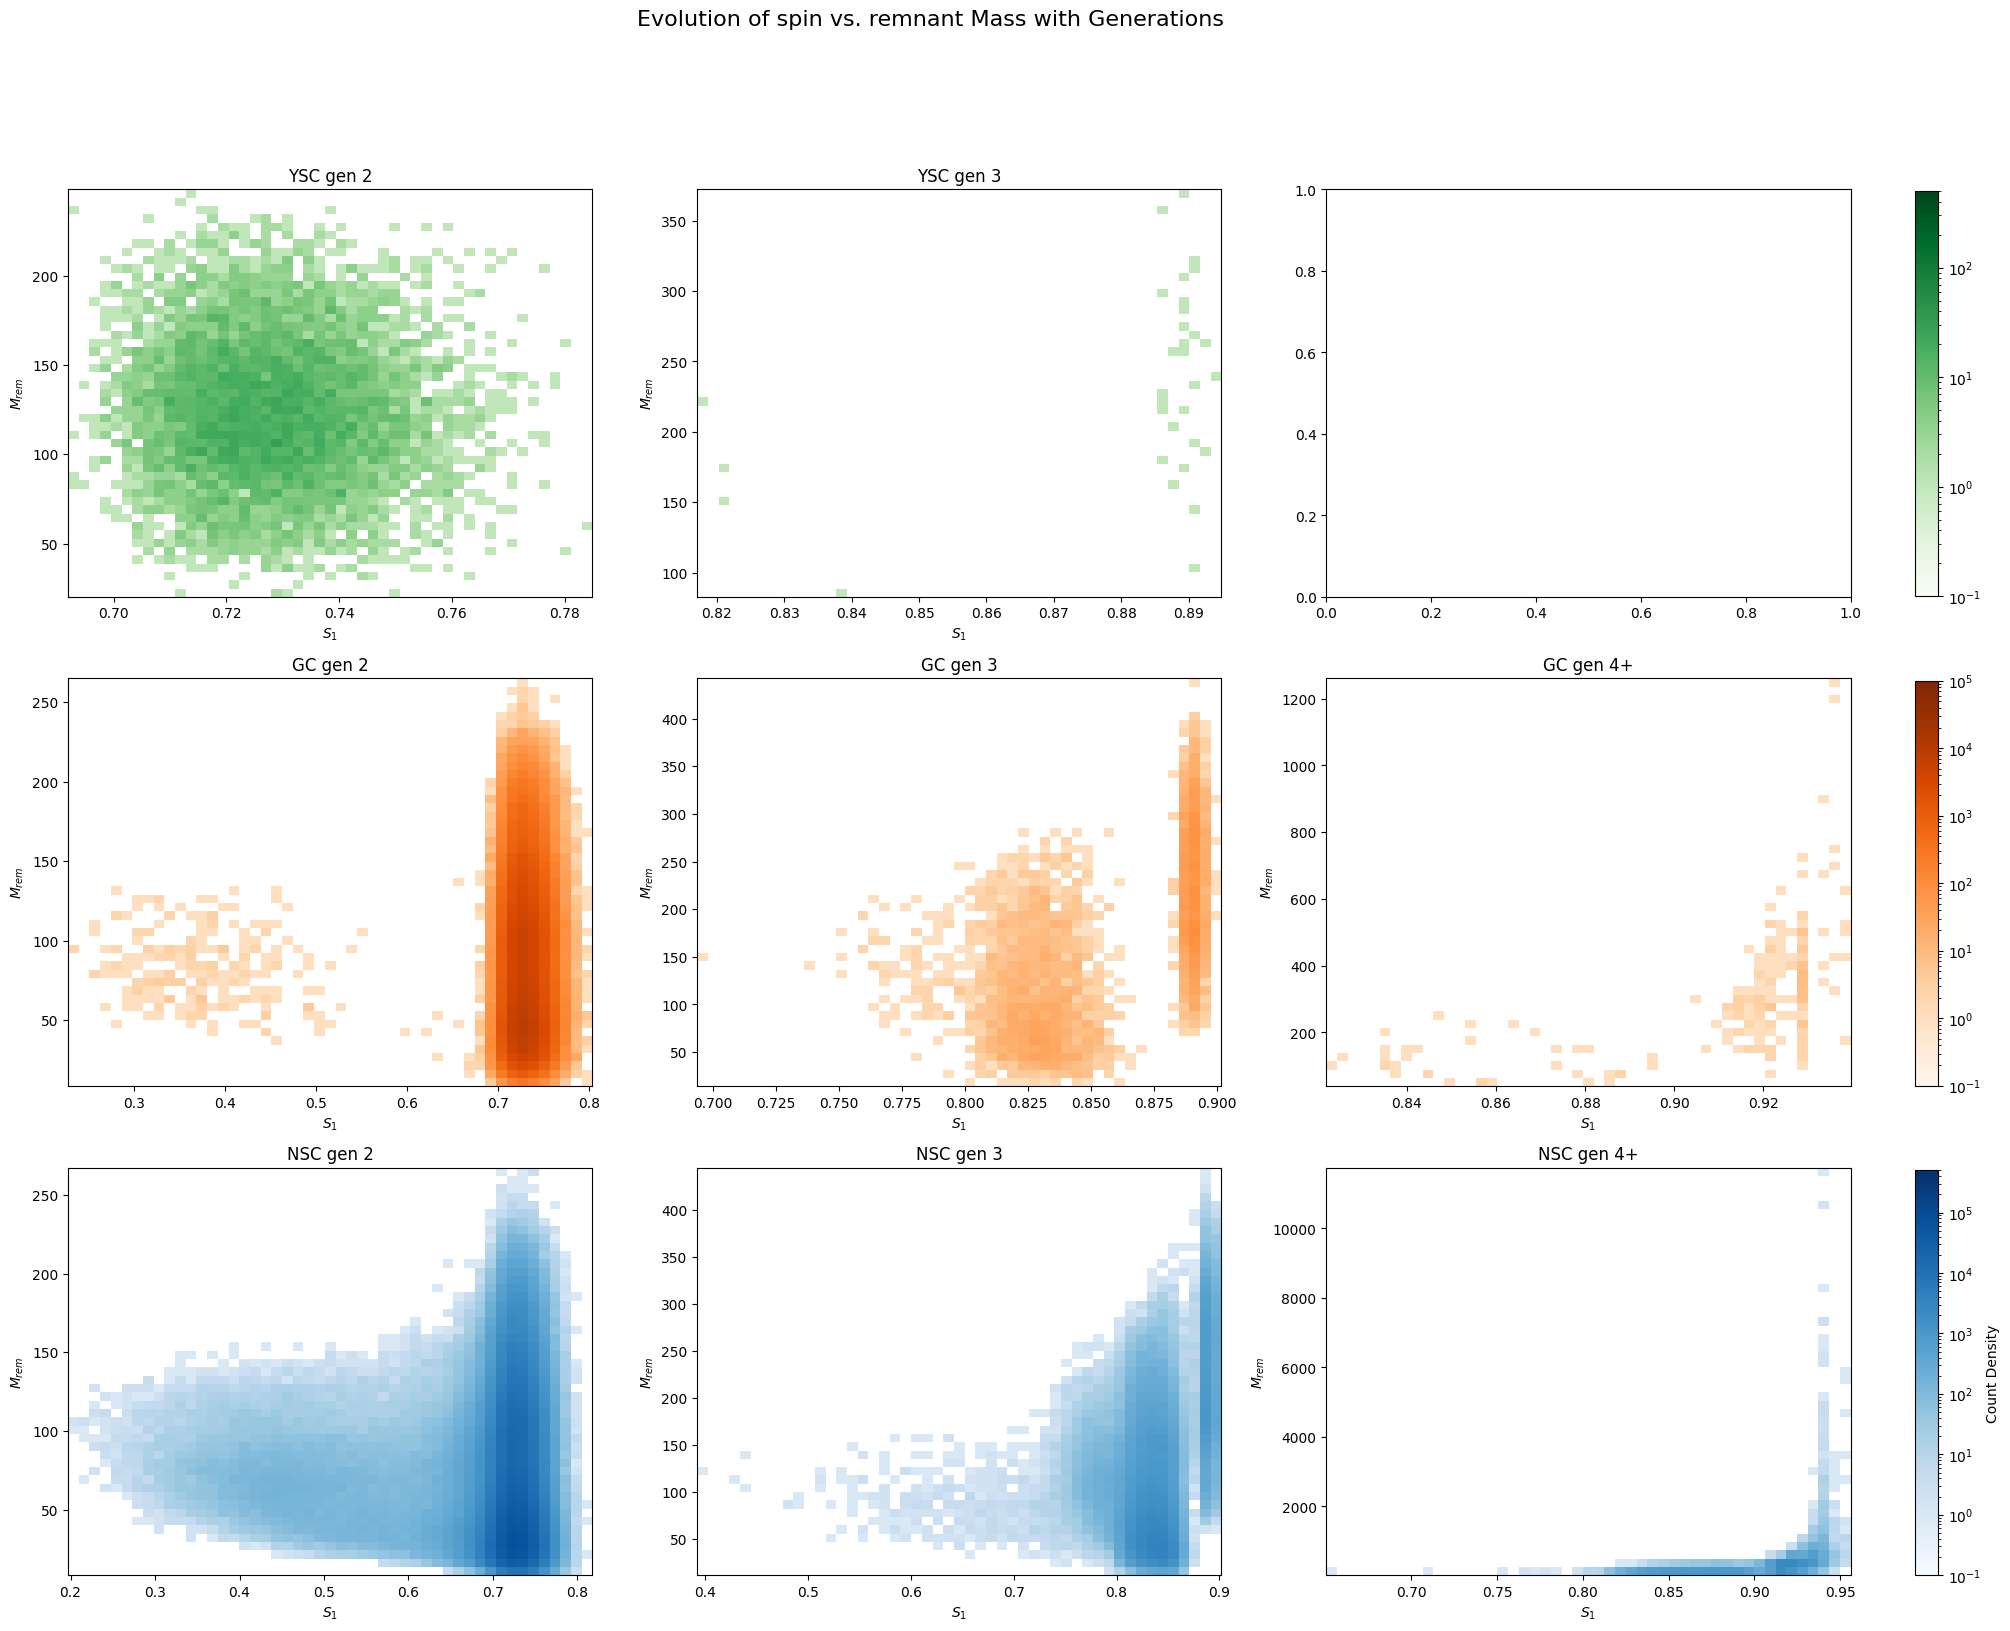

In [165]:
fig,ax=plt.subplots(3,3,figsize=(23,18))
fig.suptitle("Evolution of spin vs. remnant Mass with Generations", fontsize=16)

plt.sca(ax[0,0])
hist_ysc=hist2dgraph(data_ysc_a.S1,data_ysc_a.Mrem,50,50,'YSC gen 2',u'$S_1$', u'$M_{rem}$', 0.1, 5e2,cmap='Greens')
plt.sca(ax[0,1])
hist_ysc=hist2dgraph(data_ysc_b.S1,data_ysc_b.Mrem,50,50,'YSC gen 3',u'$S_1$', u'$M_{rem}$', 0.1, 5e2,cmap='Greens')
plt.sca(ax[0,2])
#hist_ysc=hist2dgraph(data_ysc_c.S1,data_ysc_c.Mrem,50,50,'YSC',u'$S_1$', u'$M_{rem}$', 0.1, 5e2,cmap='Greens')

cbar_ax = fig.add_axes([0.928, 0.654, 0.01, 0.225]) 
fig.colorbar(hist_ysc[3], cax=cbar_ax, ax=ax[0])

plt.sca(ax[1,0])
hist_gc=hist2dgraph(data_gc_a.S1,data_gc_a.Mrem,50,50,'GC gen 2',u'$S_1$', u'$M_{rem}$', 0.1, 1e5,cmap='Oranges')
plt.sca(ax[1,1])
hist_gc=hist2dgraph(data_gc_b.S1,data_gc_b.Mrem,50,50,'GC gen 3',u'$S_1$', u'$M_{rem}$', 0.1, 1e5,cmap='Oranges')
plt.sca(ax[1,2])
hist_gc=hist2dgraph(data_gc_c.S1,data_gc_c.Mrem,50,50,'GC gen 4+',u'$S_1$', u'$M_{rem}$', 0.1, 1e5,cmap='Oranges')

cbar_ax = fig.add_axes([0.928, 0.382, 0.01, 0.225])
fig.colorbar(hist_gc[3], cax=cbar_ax, ax=ax[1])

plt.sca(ax[2,0])
hist_nsc=hist2dgraph(data_nsc_a.S1,data_nsc_a.Mrem,50,50,'NSC gen 2',u'$S_1$', u'$M_{rem}$', 0.1, 5e5)
plt.sca(ax[2,1])
hist_nsc=hist2dgraph(data_nsc_b.S1,data_nsc_b.Mrem,50,50,'NSC gen 3',u'$S_1$', u'$M_{rem}$', 0.1, 5e5)
plt.sca(ax[2,2])
hist_nsc=hist2dgraph(data_nsc_c.S1,data_nsc_c.Mrem,50,50,'NSC gen 4+',u'$S_1$', u'$M_{rem}$', 0.1, 5e5)

cbar_ax = fig.add_axes([0.928, 0.11, 0.01, 0.225]) 
fig.colorbar(hist_nsc[3], cax=cbar_ax,ax=ax[2], label="Count Density")

### Remnant Mass vs. Metallicity

We observe a slightily descending trend, especially in YSCs: the higher the metallicity, the smaller the mass of the remnant is. This makes sense as in high-metallicity clusters, stellar winds are more effective and limit the formation of high-mass BHs.

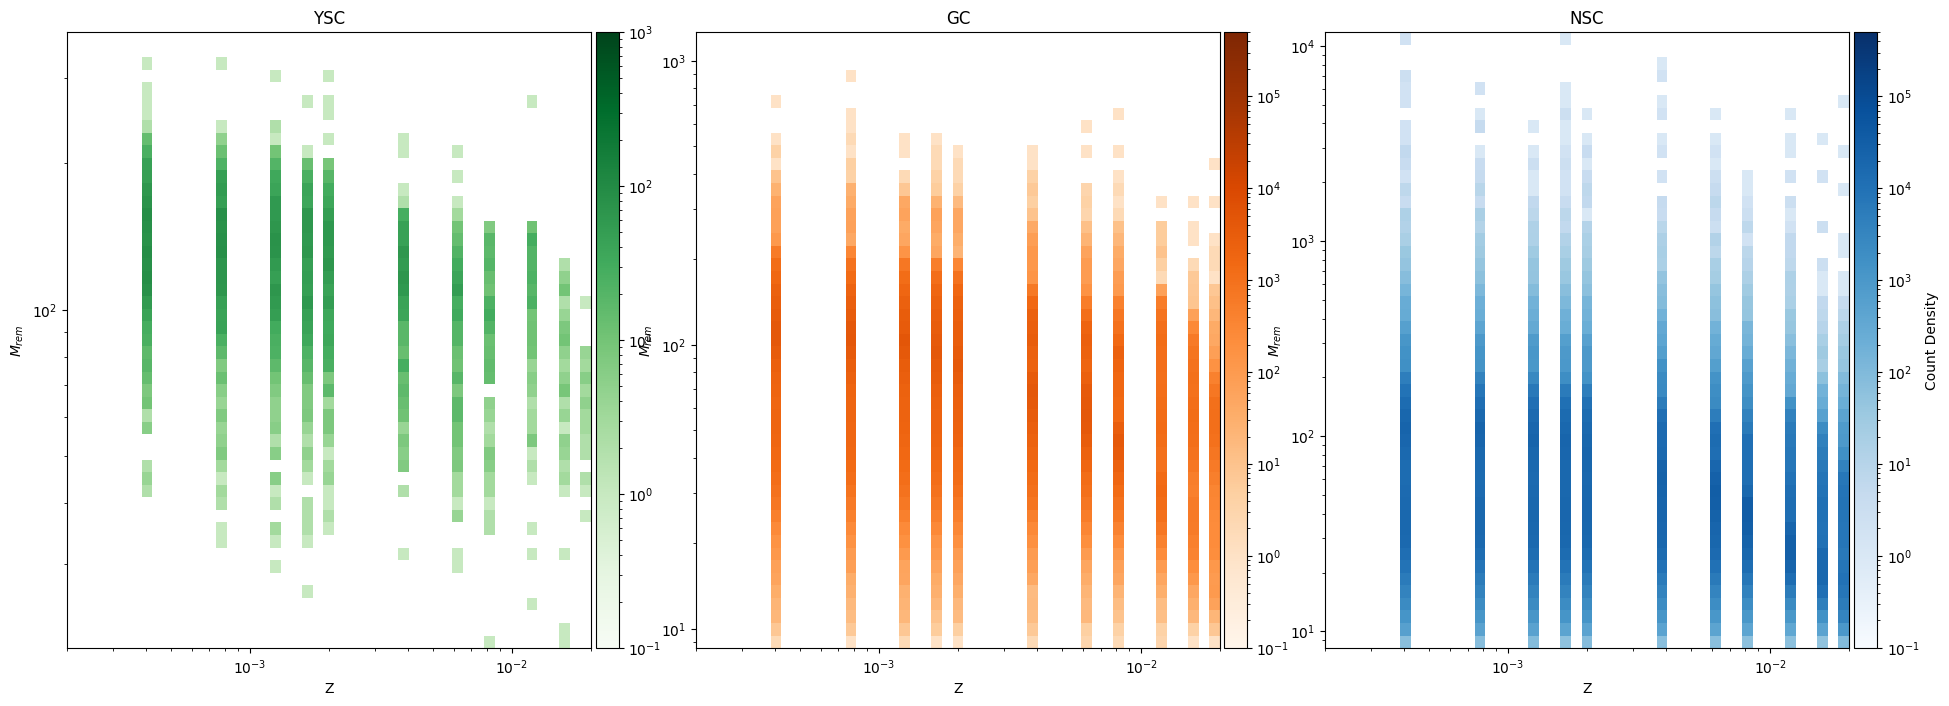

In [149]:
fig,ax=plt.subplots(1,3,figsize=(23,8))
plt.sca(ax[0])

hist_ysc=hist2dgraph(data_ysc.Z,data_ysc.Mrem,50,50,'YSC','Z', u'$M_{rem}$', 0.1, 1e3,'log','log',cmap='Greens')
#plt.ylim(7e0,2e4)
#plt.xlim(8e0,1e4)
cbar_ax = fig.add_axes([0.355, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_ysc[3], cax=cbar_ax, ax=ax[0])
plt.sca(ax[1])
hist_gc=hist2dgraph(data_gc.Z,data_gc.Mrem,50,50,'GC',u'Z', u'$M_{rem}$', 0.1, 5e5,'log','log',cmap='Oranges')
#plt.ylim(7e0,2e4)
#plt.xlim(8e0,1e4)
cbar_ax = fig.add_axes([0.628, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_gc[3], cax=cbar_ax, ax=ax[1])
plt.sca(ax[2])
hist_nsc=hist2dgraph(data_nsc.Z,data_nsc.Mrem,50,50,'NSC','Z', u'$M_{rem}$', 0.1, 5e5,'log','log')
#plt.ylim(8e0,2e4)
#plt.xlim(6e0,1e4)
cbar_ax = fig.add_axes([0.902, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]

fig.colorbar(hist_nsc[3], cax=cbar_ax,ax=ax[2], label="Count Density")

### PROVA: Srem VS S2 - da risultato del regressor
DA METTERE UNITA' DI MISURA NEI GRAFICI

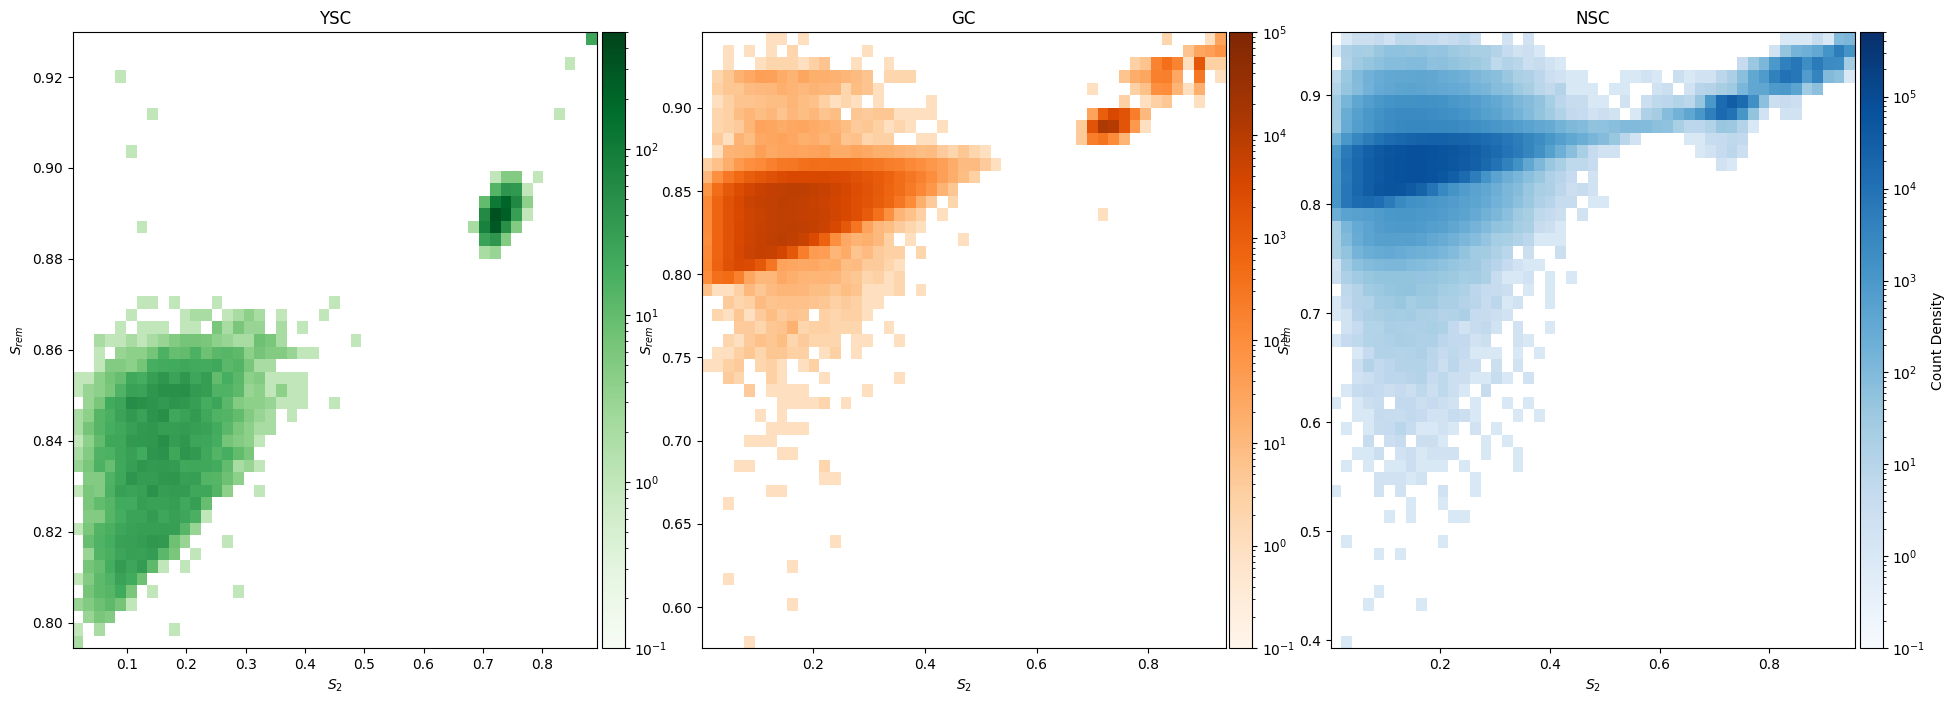

In [143]:
fig,ax=plt.subplots(1,3,figsize=(23,8))
#ax.set_title("Mcluster vs. Mrem", fontsize=16)
plt.sca(ax[0])

hist_ysc=hist2dgraph(data_ysc.S2,data_ysc.Srem,50,50,'YSC',u'$S_{2}$', u'$S_{rem}$', 0.1, 5e2,cmap='Greens')
#plt.ylim(7e0,2e4)
#plt.xlim(8e0,1e4)
cbar_ax = fig.add_axes([0.355, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_ysc[3], cax=cbar_ax, ax=ax[0])
plt.sca(ax[1])
hist_gc=hist2dgraph(data_gc.S2,data_gc.Srem,50,50,'GC',u'$S_{2}$', u'$S_{rem}$', 0.1, 1e5,cmap='Oranges')
#plt.ylim(7e0,2e4)
#plt.xlim(8e0,1e4)
cbar_ax = fig.add_axes([0.628, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_gc[3], cax=cbar_ax, ax=ax[1])
plt.sca(ax[2])
hist_nsc=hist2dgraph(data_nsc.S2,data_nsc.Srem,50,50,'NSC',u'$S_{2}$', u'$S_{rem}$', 0.1, 5e5)
#plt.ylim(8e0,2e4)
#plt.xlim(6e0,1e4)
cbar_ax = fig.add_axes([0.902, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]

fig.colorbar(hist_nsc[3], cax=cbar_ax,ax=ax[2], label="Count Density")

### PROVA: Mcluster - Mrem

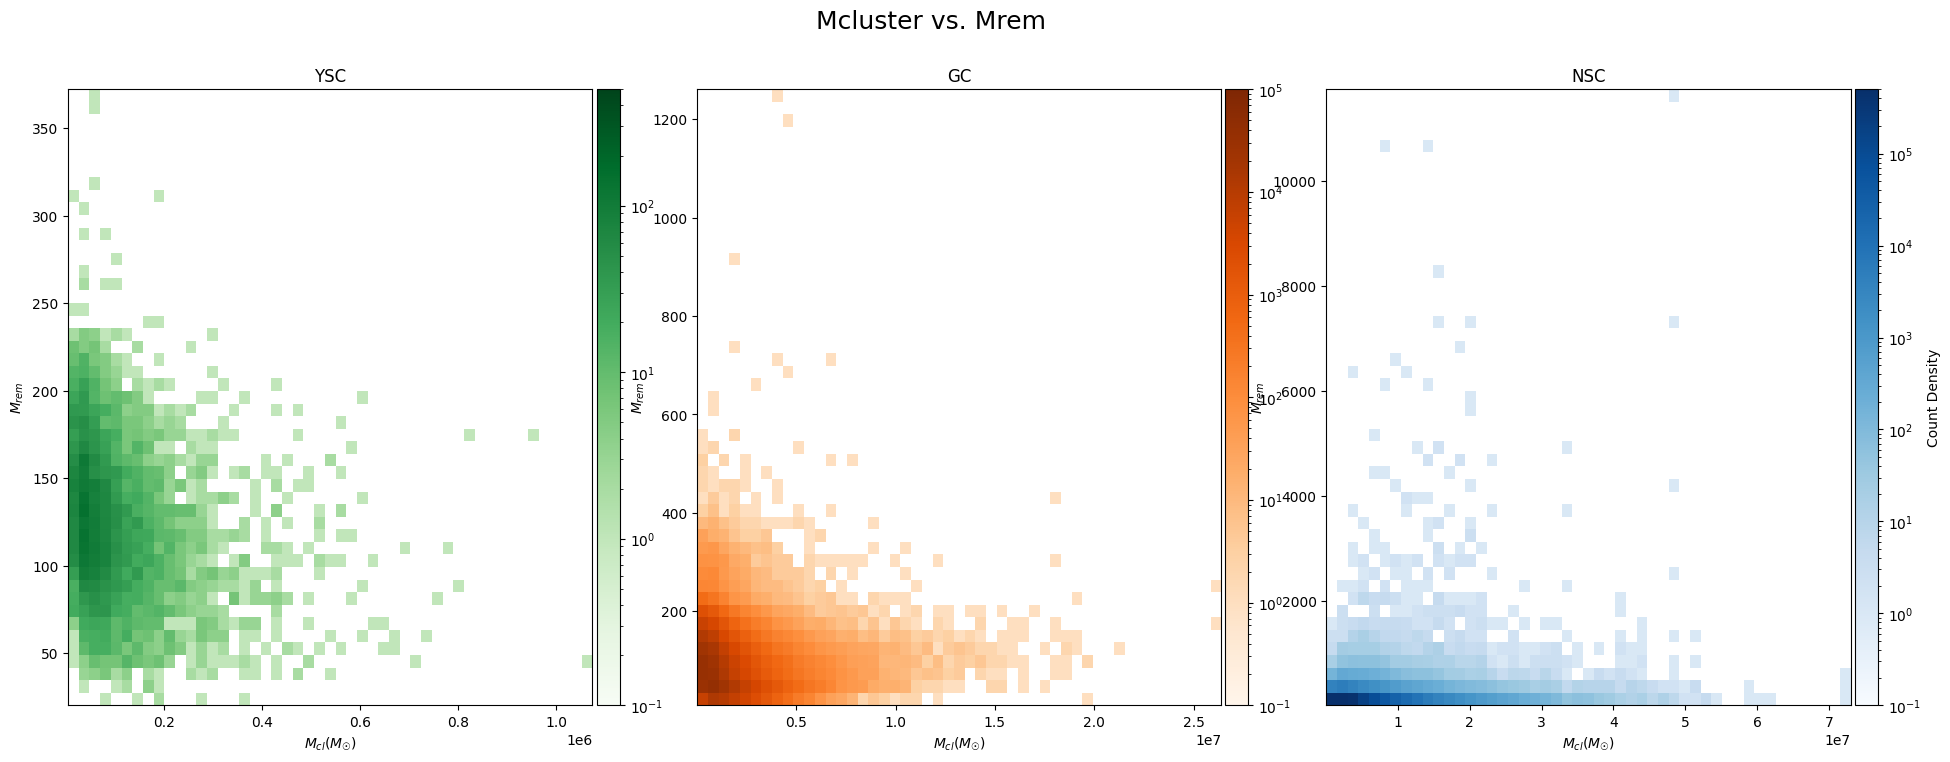

In [153]:
fig,ax=plt.subplots(1,3,figsize=(23,8))
fig.suptitle("Mcluster vs. Mrem", fontsize=18)
plt.sca(ax[0])

hist_ysc=hist2dgraph(data_ysc.Mcluster,data_ysc.Mrem,50,50,'YSC',u'$M_{cl} (M_\u2609)$', u'$M_{rem}$', 0.1, 5e2,cmap='Greens')
#plt.ylim(7e0,2e4)
#plt.xlim(8e0,1e4)
cbar_ax = fig.add_axes([0.355, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_ysc[3], cax=cbar_ax, ax=ax[0])
plt.sca(ax[1])
hist_gc=hist2dgraph(data_gc.Mcluster,data_gc.Mrem,50,50,'GC',u'$M_{cl} (M_\u2609)$', u'$M_{rem}$', 0.1, 1e5,cmap='Oranges')
#plt.ylim(7e0,2e4)
#plt.xlim(8e0,1e4)
cbar_ax = fig.add_axes([0.628, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist_gc[3], cax=cbar_ax, ax=ax[1])
plt.sca(ax[2])
hist_nsc=hist2dgraph(data_nsc.Mcluster,data_nsc.Mrem,50,50,'NSC',u'$M_{cl} (M_\u2609)$', u'$M_{rem}$', 0.1, 5e5)
#plt.ylim(8e0,2e4)
#plt.xlim(6e0,1e4)
cbar_ax = fig.add_axes([0.902, 0.11, 0.01, 0.77])  # Adjust position [left, bottom, width, height]

fig.colorbar(hist_nsc[3], cax=cbar_ax,ax=ax[2], label="Count Density")

### kick over spin 1, 2, M1, M2

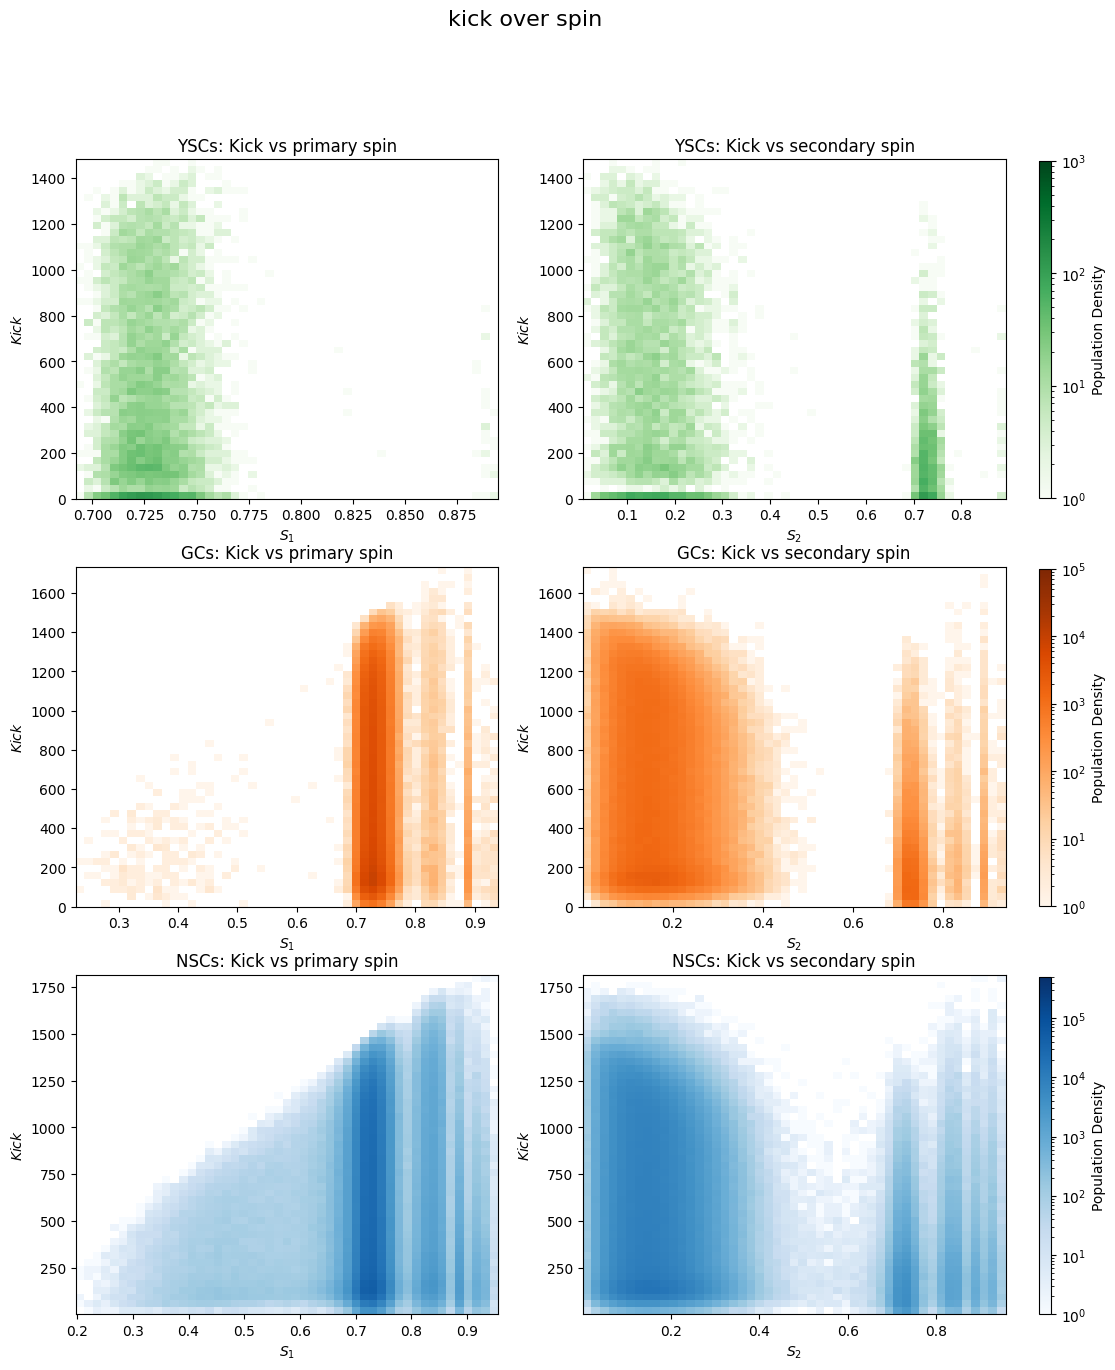

In [154]:
fig, ax = plt.subplots(3,2,figsize=(12,15))
fig.suptitle("kick over spin", fontsize=16)
plt.sca(ax[0,0])
hist = f.hist2dgraph(data_ysc.S1,data_ysc.kick,50,50,'YSCs: Kick vs primary spin',u'$S_1$', u'$Kick$', 1, 1e3, cmap='Greens')
plt.sca(ax[0,1])
hist2 = f.hist2dgraph(data_ysc.S2,data_ysc.kick,50,50,'YSCs: Kick vs secondary spin',u'$S_2$', u'$Kick$', 1, 1e3,cmap='Greens')
cbar_ax = fig.add_axes([0.928, 0.654, 0.01, 0.225])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist2[3], cax=cbar_ax, ax=ax[0,1],label='Population Density')


plt.sca(ax[1,0])
hist = f.hist2dgraph(data_gc.S1,data_gc.kick,50,50,'GCs: Kick vs primary spin',u'$S_1$', u'$Kick$', 1, 1e5,cmap='Oranges')
plt.sca(ax[1,1])
hist2 = f.hist2dgraph(data_gc.S2,data_gc.kick,50,50,'GCs: Kick vs secondary spin',u'$S_2$', u'$Kick$', 1, 1e5,cmap='Oranges')
cbar_ax = fig.add_axes([0.928, 0.382, 0.01, 0.225])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist2[3], cax=cbar_ax, ax=ax[1,1],label='Population Density')

plt.sca(ax[2,0])
hist = f.hist2dgraph(data_nsc.S1,data_nsc.kick,50,50,'NSCs: Kick vs primary spin',u'$S_1$', u'$Kick$', 1, 5e5)
plt.sca(ax[2,1])
hist2 = f.hist2dgraph(data_nsc.S2,data_nsc.kick,50,50,'NSCs: Kick vs secondary spin',u'$S_2$', u'$Kick$', 1, 5e5)
cbar_ax = fig.add_axes([0.928, 0.11, 0.01, 0.225])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist2[3], cax=cbar_ax, ax=ax[2,1],label='Population Density')

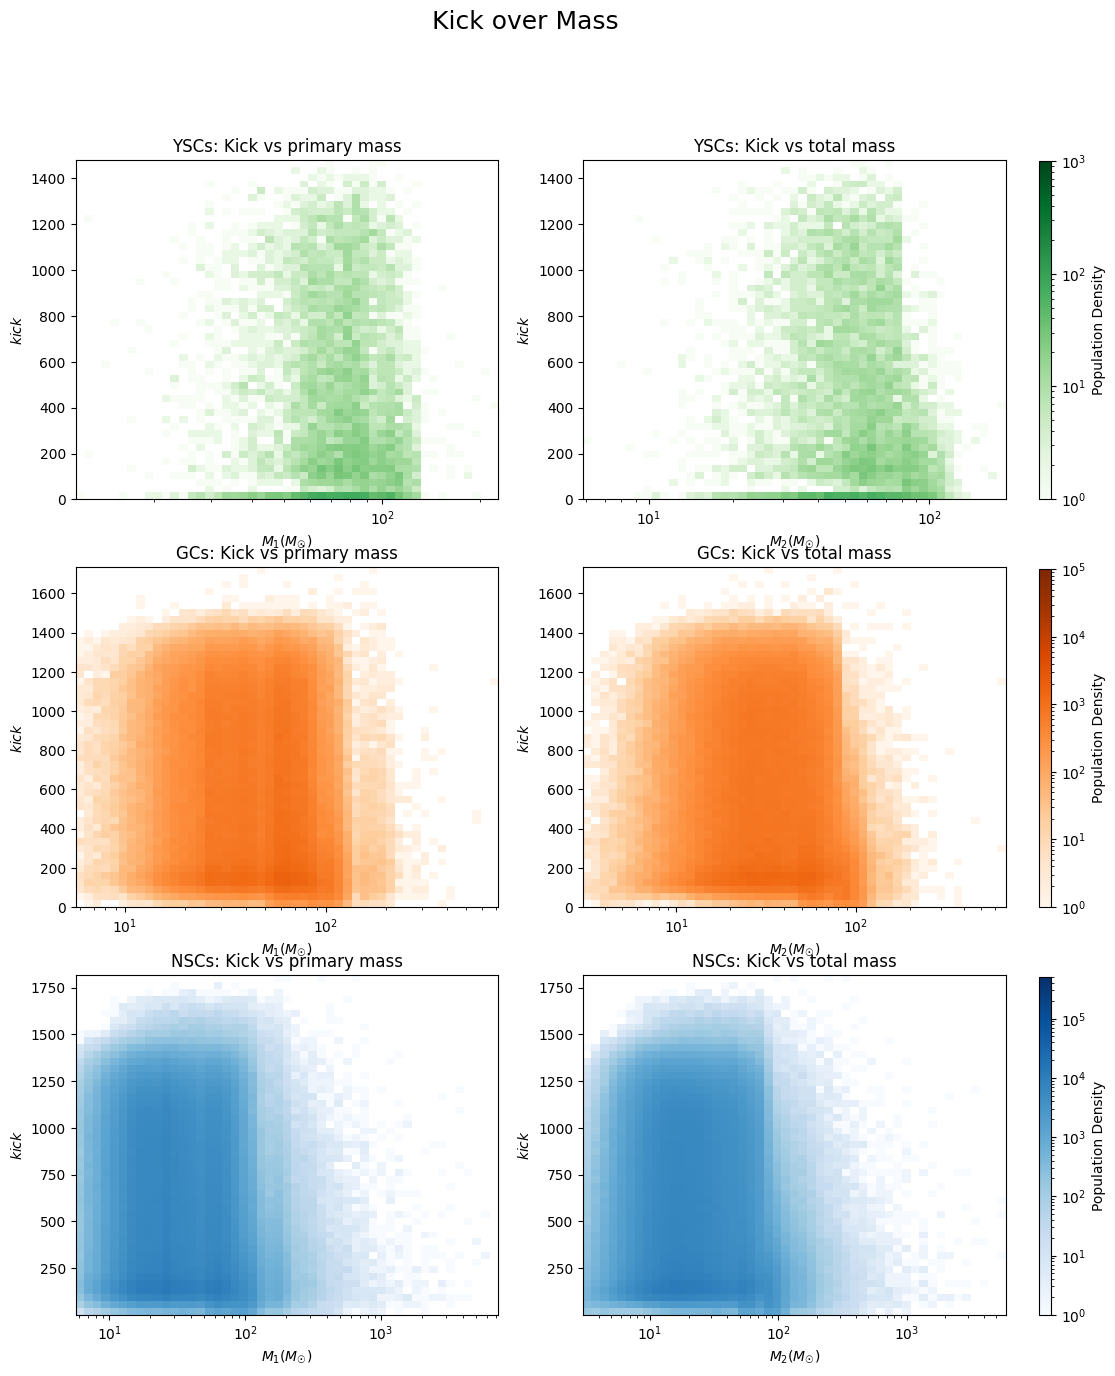

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(12,15))
fig.suptitle("Kick over Mass", fontsize=18)
plt.sca(ax[0,0])
hist = f.hist2dgraph(data_ysc.M1,data_ysc.kick,50,50,'YSCs: Kick vs primary mass',u'$M_1 (M_\u2609)$', u'$kick$', 1, 1e3, scale_x='log',cmap='Greens')
plt.sca(ax[0,1])
hist2 = f.hist2dgraph(data_ysc.M2,data_ysc.kick,50,50,'YSCs: Kick vs total mass',u'$M_2 (M_\u2609)$', u'$kick$', 1, 1e3,scale_x='log',cmap='Greens')
cbar_ax = fig.add_axes([0.928, 0.654, 0.01, 0.225])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist2[3], cax=cbar_ax, ax=ax[0,1],label='Population Density')


plt.sca(ax[1,0])
hist = f.hist2dgraph(data_gc.M1,data_gc.kick,50,50,'GCs: Kick vs primary mass',u'$M_1 (M_\u2609)$', u'$kick$', 1, 1e5, scale_x='log',cmap='Oranges')
plt.sca(ax[1,1])
hist2 = f.hist2dgraph(data_gc.M2,data_gc.kick,50,50,'GCs: Kick vs total mass',u'$M_2 (M_\u2609)$', u'$kick$', 1, 1e5, scale_x='log',cmap='Oranges')
cbar_ax = fig.add_axes([0.928, 0.382, 0.01, 0.225])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist2[3], cax=cbar_ax, ax=ax[1,1],label='Population Density')

plt.sca(ax[2,0])
hist = f.hist2dgraph(data_nsc.M1,data_nsc.kick,50,50,'NSCs: Kick vs primary mass',u'$M_1 (M_\u2609)$', u'$kick$', 1, 5e5, scale_x='log')
plt.sca(ax[2,1])
hist2 = f.hist2dgraph(data_nsc.M2,data_nsc.kick,50,50,'NSCs: Kick vs total mass',u'$M_2 (M_\u2609)$', u'$kick$', 1, 5e5, scale_x='log')
cbar_ax = fig.add_axes([0.928, 0.11, 0.01, 0.225])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist2[3], cax=cbar_ax, ax=ax[2,1],label='Population Density')

### Other

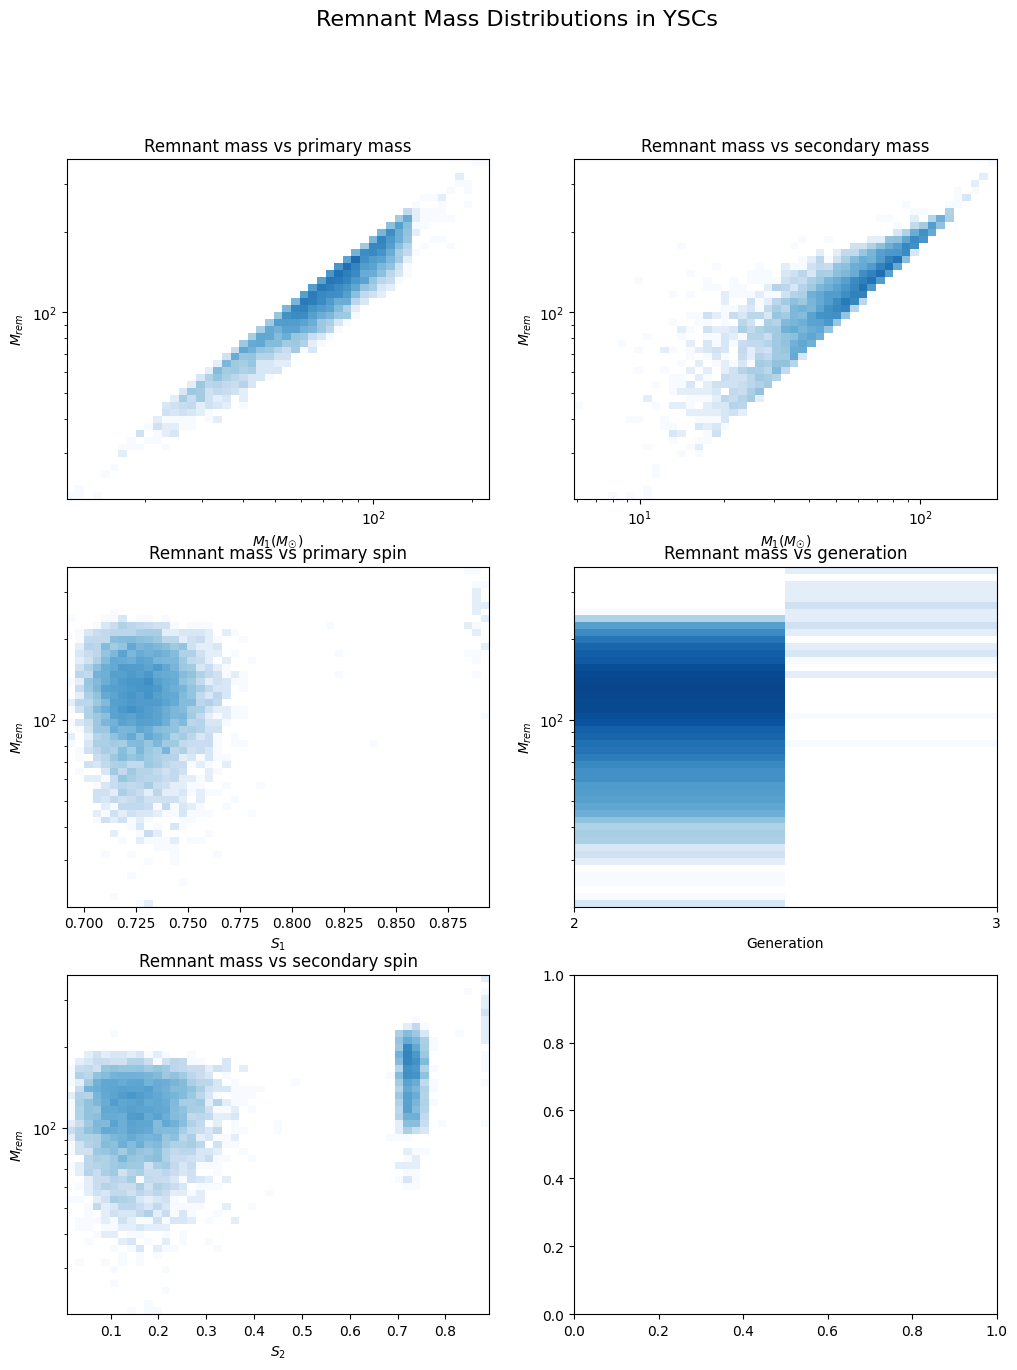

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(12,15))
fig.suptitle("Remnant Mass Distributions in YSCs", fontsize=16)
plt.sca(ax[0,0])
hist = f.hist2dgraph(data_ysc.M1,data_ysc.Mrem,50,50,'Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e3, 'log','log')
plt.sca(ax[0,1])
hist2 = f.hist2dgraph(data_ysc.M2,data_ysc.Mrem,50,50,'Remnant mass vs secondary mass',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e3, 'log','log')
plt.sca(ax[1,0])
hist = f.hist2dgraph(data_ysc.S1,data_ysc.Mrem,50,50,'Remnant mass vs primary spin',u'$S_1$', u'$M_{rem}$', 1, 1e3, 'linear','log')
plt.sca(ax[1,1])
hist2 = f.hist2dgraph(data_ysc.gen,data_ysc.Mrem,3,50,'Remnant mass vs generation',u'Generation', u'$M_{rem}$', 1, 1e3, 'linear','log')
plt.xticks([2,3])
plt.sca(ax[2,0])
jist3 = f.hist2dgraph(data_ysc.S2,data_ysc.Mrem,50,50,'Remnant mass vs secondary spin',u'$S_2$', u'$M_{rem}$', 1, 1e3, 'linear','log')
plt.sca(ax[2,1])

### Appunti importanti da discussione con Gigi.

In [ ]:
# TODO spin rho e spin efficace da capire cosa sono e sono divertenti da plottare.
#kick: è una funzione di questi due e del rapporto m1/m2

# 
# TROVARE LE UNITÀ DI MISURA 

TODO:
plot features 1 a 1, per tipo di cluster

massa cluster da plottare

distribuzioni iniziali (fa gigi)

massa rem vs massa primaria
massa buco nero è praticamente massa primaria, e somma delle due masse
c'è molta più coda nel secondo grafico
più diverse sono le masse e piu grande è il kick (merge asimmetrico) per conservazione della quantità di moto dell'oggetto. Le due masse si fondono, soccombono alla stessa loro forza e la massa precipita verso il centro. C'è una sorta di bounce che potys a eiezione della massa. Se eiezione è asimmetrica, molta massa va da una parte e il remnant assume una velocità specifica che è il kick e pyuò superare la escape velociuty. Se abbastanza grande l'oggetto può evaporare dal cluster. 

remnant vs spin deve tener conto delle generazioni
si vede che lo spin del remnant parte da una distribuzione : spin ha picco centrale nelle prime generazioni e rimane piccato per ysc, per gli altri si picca ddopo
Spin secondario invece è a due picchi, uno come l'altro e uno più piccolo. Condizioni iniziali, punto. è figo vedere che lo spin del remnant si sposta verso 1 progressivamente perchè lo spin nel remnant diventa spin primario nella gen successiva ed è circa la somma dei due spin. C'è una formula più specifica nel paper. 

remnant vs generation è da togliere.
remnant vs primary anche lui è copia della animazione.
spin secondario aumenta con la generazione
spin secondario vs remnant mass è stessa cosa spin primario

metallicità: massa buco nero è inversamente prop alla metallicità per i venti stellari che sono efficaci quando la metallicità è alta.

si può fare un regressor con massa 1 e vedere se è correlato con la metallicità. Possiamo capire se la massa dipende da altre features oltre che la z.

GC
prop tra massa 1 e massa remnant, coda più grande per come viene presa la massa secondaria. è più marcato perchè ci sono più dati.
distribuzione spin. é come li ha generati il dataset e basta

remnant vs generazione: cresce con la generazione.
massa cluster vs remnant: non c'è correlazione!

NSC
massa remnant vs tempo elapsed, no correlazione, con tutte le generazioni.
GUARDA COME RAGGRUPPARE SU CODICE GIO

t su massa remnant: più basssso è il tempo di pairing vuol dire che la masse sono più grande e hai più tempo per mergiare ancora nel tempo elapsed. 
Grafico in basso a destra di nuovo è da cambiare.

REMNANT MASS DISTRIBUTION IN GCS
interessanti.
cp,e cambia lo spin primario con la generazione. Lo spin è legsyo alle generazioni in quanto legato alo spin del remnant. A destra la balena: due picchi dello spin secondarip. Il picco basso sparisce al salire della generazione. Da CAPIRE COME È GENERATO LO SPIN SECONDARIO
massa primaria è la massa remnent cìdella gen prima, che cresce rispetto a quella prima chiaramente. 
gen vs cluster mass. Quando prendi ysc, sono tanti cluster di quel tiopo e per ognuno ci sono dei merge. Si vede qui che i cluster con gen più alte hanno masse più alte generalmente. 
gen vs tempo elapsed ha senso: più passsa il tempo e più la gen è alta.
Gen vs pair time: (Asse sbagliato) non ha senso di esistere. non dà nessuna informazione. C'è da dire che il tempo elapsed è somma dei pair time più tempo che buco nero ci mette a tornare dentro dopo vkick e il tempo che ci impiega per incontrare un altro. Sembra che le gen più alte abbiano bisogno di meno pair time, ma è perchè c'è il cap dell'Hubble time che non deve essere superto ed è ghià passato tanto tempo quando arrivi ad alta generazione e quindi debono metterci poco per vederli.

NSC FINALE
Spin rispeyyo a generazioni è più accentuato semplicemente.
Aumenta verso spin 1 perchè spin è somma degli spin precedenti
Grafico balena come al solito.
Massa 1 vs generazione cresce: perchè è la massa remnant della gen precedente.
2 grafici già parlato prima
gen vs z inutile.

poi covaRIANXZA BELLA CIAO BELLA CIAO

Altro modo simpatico al posto della cov matrix è sto altro metodo che sta provando gigi. Grafico ragnatela da rivedere


i cluster più giovani sono piu piccolo e hanno meno time elapsed quindi meno esc vel e hanno quindi meno generazioni, tutto qui. Infatti vedremo distribuzioni simili. 

prima hai trainato il classifier usando solo l'arrivo (ultima generazione ) quindi le caratteristiche del remnant finalissimo. Li sputa fuori che il time elapsed è molto importsnte e la massa del cluster.
dato che generazioni alte sono poche poch e il random forest fallisce perchè non trova cose intelligenti. Quindi studiamo insieme le generazioni da tre in poi.

LE COSE PIÙ IMPORTANTI SONO VESC E MASSA DEL CLUSTER